In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import PIL.Image
from pathlib import Path
import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
import time
import timm

In [ ]:
IMAGE_SIZE = 192 #128
BATCH_SIZE = 16 #32
nfolds = 4
fname = 'resnet50'#'resnext50'#'RSNT18'
IMAGE_DIR = '/kaggle/input/panda-16x192x192/train_16_192'#'/kaggle/input/panda-16x128x128-tiles-data/train'
LABELS = '/kaggle/input/prostate-cancer-grade-assessment/train.csv'
SEED = 2024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# loss_name = "mse"
# TRAIN_DATASET_FRAC = 1
# num_epochs = 50
# EARLY_STOPPING = True
# MIN_EPOCH = 20
# PATIENCE = 10

loss_name = "mse"
TRAIN_DATASET_FRAC = 1
num_epochs = 20
EARLY_STOPPING = True
MIN_EPOCH = 10
PATIENCE = 8

## Seed everything

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Dataset class

In [ ]:
class ProstateTilesDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, n_tiles=(3, 4), transform=None):
        self.df = df
        self.image_dir = image_dir
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row.image_id
        label = row.isup_grade
        tile_rows, tile_cols = self.n_tiles
        imgs = []
        for i in range(tile_rows):
            for j in range(tile_cols):
                img_path = Path(self.image_dir, f'{img_id}_{i * tile_cols + j}.png')
                img = PIL.Image.open(img_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
        imgs = torch.stack(imgs) # (12, 3, 128, 128)
        return imgs, label

## Model

In [ ]:
class CustomPool(nn.Module):
    def __init__(self, N=12):
        super(CustomPool, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size=N)
        self.max_pool = nn.MaxPool1d(kernel_size=N)

    def forward(self, x):
        # x = (BS, 12, 2048)
        x = x.transpose(1, 2)  # (BS, 512, 12)
        avg_pooled = self.avg_pool(x).squeeze(-1)  # (BS, 512)
        max_pooled = self.max_pool(x).squeeze(-1)  # (BS, 512)
        concatenated_features = torch.cat((avg_pooled, max_pooled), dim=1)  # (BS, 512*2)
        return concatenated_features

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=1): # change back to 6
        super().__init__()
        #self.enc = timm.create_model('resnet18', pretrained=True, num_classes=0)
        #self.enc = timm.create_model('resnext50_32x4d.fb_ssl_yfcc100m_ft_in1k', pretrained=True, num_classes=0)
        self.enc = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=0)


        nc = self.enc.feature_info[-1]['num_chs']
        self.pool = CustomPool()
        self.head = nn.Sequential(
            nn.Linear(nc*2,512), # (BS, 12, 512)
            nn.Mish(),
            nn.Dropout(0.25),
            nn.Linear(512,num_classes)
        )

    def forward(self, x):
        # x = (BS, 12, 3, 128, 128)
        n = x.shape[1]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (BS*12, 3, 128, 128)
        x = self.enc(x) # (BS*12, nc)
        x = x.view(-1,n,x.shape[1]) # (BS, 12, nc)
        x = self.pool(x) # (BS, 512*2)
        x = self.head(x)
        return x

## Training utility functions

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Train"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs)
            if loss_name == "mse":
                loss = criterion(outputs.squeeze(-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    return average_loss

In [ ]:
def go_from_mse_logit_to_prediction(logit):
    if logit < 0.5:
        return 0
    elif logit < 1.5:
        return 1
    elif logit < 2.5:
        return 2
    elif logit < 3.5:
        return 3
    elif logit < 4.5:
        return 4
    else:
        return 5

In [ ]:
def tune(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Tune"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float()
                outputs = model(inputs)
                if loss_name == "mse":
                    loss = criterion(outputs.squeeze(-1), labels)
                else:
                    loss = criterion(outputs, labels)
                total_loss += loss.item()
                if loss_name == "mse":
                    preds = [go_from_mse_logit_to_prediction(o) for o in outputs]
                else:
                    preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    elapsed_time = end_time - start_time
    kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return average_loss, kappa, all_preds, all_labels

In [ ]:
def log_metrics(epoch, fold, train_loss, tune_loss, kappa):
    logs = {'epoch': epoch, 'fold': fold, 'train_loss': train_loss, 'tune_loss': tune_loss, 'kappa': kappa}
    logs_folder = Path("/kaggle/working/logs")
    logs_folder.mkdir(exist_ok=True)
    log_file = Path(logs_folder, f'log_{fname}_{fold}.json')
    if log_file.is_file():
        with open(log_file, 'r') as file:
            data = json.load(file)
    else:
        data = []
    data.append(logs)
    with open(log_file, 'w') as file:
        json.dump(data, file)

In [ ]:
def save_best_model(model, best_val, current_val, fold, epoch, min_max="min"):
    improve_flag = False
    if min_max == "max":
        best_val = -1 * best_val
        current_val = -1 * current_val
    if current_val < best_val:
        improve_flag = True
        best_val = current_val
        torch.save(model.state_dict(), f'{fname}_{fold}.pth')
        print(f"Saved better model for fold {fold} at epoch {epoch}")
    if min_max == "max":
        best_val = -1 * best_val
    return best_val, improve_flag

## Model training

In [ ]:
df = pd.read_csv(LABELS)
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [ ]:
# grab slide ids in /kaggle/input/panda-16x128x128-tiles-data
slide_ids = list(set([fp.stem.split("_")[0] for fp in Path(IMAGE_DIR).glob("*.png")]))
len(slide_ids)

10516

In [ ]:
# restrict previous dataframe to those ids
df_restricted = df[df.image_id.isin(slide_ids)].reset_index(drop=True)
len(df) - len(df_restricted)

100

In [ ]:
skf = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
X = df_restricted.image_id.values
y = df_restricted.isup_grade.values
train_dfs, tune_dfs = [], []
for i, (train_index, tune_index) in enumerate(skf.split(X, y)):
    train_df, tune_df = df_restricted.loc[train_index], df_restricted.loc[tune_index]
    if TRAIN_DATASET_FRAC < 1.0:
        train_df = train_df.sample(frac=TRAIN_DATASET_FRAC, random_state=SEED)
    train_df = train_df.reset_index(drop=True)
    tune_df = tune_df.reset_index(drop=True)
    train_dfs.append(train_df)
    tune_dfs.append(tune_df)
    print(f"fold {i+1}/{nfolds}: train={len(train_df)}, tune={len(tune_df)}")

fold 1/4: train=7887, tune=2629
fold 2/4: train=7887, tune=2629
fold 3/4: train=7887, tune=2629
fold 4/4: train=7887, tune=2629


In [ ]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),

#     # more augmentations (added):
#     transforms.RandomResizedCrop(size=int(0.85*IMAGE_SIZE)),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=[-0.03,0.04]),


    transforms.ToTensor(),
    transforms.Normalize(mean, std)

])

In [ ]:
def show_image(img_tensor, title):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
all_folds_preds = []
all_folds_labels = []
for fold in range(nfolds):

    train_dataset = ProstateTilesDataset(train_dfs[fold], IMAGE_DIR, transform=transform)
    tune_dataset = ProstateTilesDataset(tune_dfs[fold], IMAGE_DIR, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    tune_loader = torch.utils.data.DataLoader(tune_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    if loss_name == "mse":
        num_classes =  1
        criterion = nn.MSELoss()
    else:
        num_classes = 6
        criterion = nn.CrossEntropyLoss()

    model = Model(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_kappa = -np.inf
    best_loss = np.inf
    best_fold_dict = {
            "epochs": [None] * num_epochs,
            "kappa": [None] * num_epochs,
            "preds": [None] * num_epochs,
            "labels": [None] * num_epochs,
            "loss": [float('inf')] * num_epochs
        }



    early_stopping_count = 0

    with tqdm(
        range(num_epochs),
        desc=f"Fold {fold+1}/{nfolds}",
        unit=" epoch",
        leave=True,
    ) as t:
        for epoch in t:
            train_loss = train(model, train_loader, criterion, optimizer, device)
            tqdm.write(f"Epoch {epoch} - train_loss: {train_loss:.4f}")
            valid_loss, kappa, fold_preds, fold_labels = tune(model, tune_loader, criterion, device)
            tqdm.write(f"Epoch {epoch} - tune loss: {valid_loss:.4f}")
            tqdm.write(f"Epoch {epoch} - tune kappa: {kappa:.4f}")
            log_metrics(epoch, fold, train_loss, valid_loss, kappa)

            best_fold_dict["epochs"][epoch] = (epoch + 1)
            best_fold_dict["kappa"][epoch] = kappa
            best_fold_dict["preds"][epoch] = fold_preds
            best_fold_dict["labels"][epoch] = fold_labels
            best_fold_dict["loss"][epoch] = valid_loss


            # best_kappa, improve_flag = save_best_model(model, best_kappa, kappa, fold, epoch, min_max="max")
            best_loss, improve_flag = save_best_model(model, best_loss, valid_loss, fold, epoch,  min_max="min")
            if not improve_flag:
                early_stopping_count += 1
            if EARLY_STOPPING and early_stopping_count > PATIENCE and epoch >= MIN_EPOCH:
                print(f"Epoch {epoch} - Stopping early as model didn't improve over the last {PATIENCE} epochs")
                break


    # get best epoch based on lowest loss
    min_value_index = best_fold_dict['loss'].index(min(best_fold_dict['loss']))
    best_epoch = best_fold_dict['epochs'][min_value_index]
    loss_best = best_fold_dict['loss'][min_value_index]
    print(f'Best performing epoch of fold {fold +1} is {best_epoch} with a loss of {loss_best}')

    all_folds_preds.extend(best_fold_dict["preds"][min_value_index])
    all_folds_labels.extend(best_fold_dict["labels"][min_value_index])


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Fold 1/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.7369


Epoch 0 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.6875
Epoch 0 - tune kappa: 0.6300
Saved better model for fold 0 at epoch 0


Epoch 1 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.4596


Epoch 1 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.4252
Epoch 1 - tune kappa: 0.6594
Saved better model for fold 0 at epoch 1


Epoch 2 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.2835


Epoch 2 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.3448
Epoch 2 - tune kappa: 0.7461
Saved better model for fold 0 at epoch 2


Epoch 3 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.1719


Epoch 3 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.2675
Epoch 3 - tune kappa: 0.6956
Saved better model for fold 0 at epoch 3


Epoch 4 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.0842


Epoch 4 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.5854
Epoch 4 - tune kappa: 0.5615


Epoch 5 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.9498


Epoch 5 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.3890
Epoch 5 - tune kappa: 0.7159


Epoch 6 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.8390


Epoch 6 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 2.1504
Epoch 6 - tune kappa: 0.5966


Epoch 7 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.7198


Epoch 7 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.7408
Epoch 7 - tune kappa: 0.6742


Epoch 8 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.6537


Epoch 8 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.3229
Epoch 8 - tune kappa: 0.7093


Epoch 9 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.5190


Epoch 9 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.5053
Epoch 9 - tune kappa: 0.7432


Epoch 10 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.4909


Epoch 10 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.1571
Epoch 10 - tune kappa: 0.7466
Saved better model for fold 0 at epoch 10


Epoch 11 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.4235


Epoch 11 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.3324
Epoch 11 - tune kappa: 0.7064


Epoch 12 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.3501


Epoch 12 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.3054
Epoch 12 - tune kappa: 0.7144


Epoch 13 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.3550


Epoch 13 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.1757
Epoch 13 - tune kappa: 0.7516
Epoch 13 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 1 is 11 with a loss of 1.1570671359697977


Fold 2/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.7985


Epoch 0 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.7144
Epoch 0 - tune kappa: 0.5338
Saved better model for fold 1 at epoch 0


Epoch 1 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.4805


Epoch 1 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.4853
Epoch 1 - tune kappa: 0.6767
Saved better model for fold 1 at epoch 1


Epoch 2 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.3509


Epoch 2 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.3475
Epoch 2 - tune kappa: 0.7163
Saved better model for fold 1 at epoch 2


Epoch 3 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.2516


Epoch 3 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.2270
Epoch 3 - tune kappa: 0.7364
Saved better model for fold 1 at epoch 3


Epoch 4 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.1336


Epoch 4 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.2076
Epoch 4 - tune kappa: 0.7449
Saved better model for fold 1 at epoch 4


Epoch 5 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.0290


Epoch 5 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.3269
Epoch 5 - tune kappa: 0.7301


Epoch 6 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.8845


Epoch 6 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.4845
Epoch 6 - tune kappa: 0.7050


Epoch 7 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.7834


Epoch 7 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.2603
Epoch 7 - tune kappa: 0.7421


Epoch 8 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.7014


Epoch 8 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.4727
Epoch 8 - tune kappa: 0.7157


Epoch 9 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.5832


Epoch 9 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.2930
Epoch 9 - tune kappa: 0.7018


Epoch 10 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.5411


Epoch 10 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.3711
Epoch 10 - tune kappa: 0.6770


Epoch 11 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.4307


Epoch 11 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.1583
Epoch 11 - tune kappa: 0.7731
Saved better model for fold 1 at epoch 11


Epoch 12 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.3841


Epoch 12 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.3222
Epoch 12 - tune kappa: 0.7006


Epoch 13 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.3209


Epoch 13 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.3259
Epoch 13 - tune kappa: 0.7029


Epoch 14 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.3302


Epoch 14 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.2029
Epoch 14 - tune kappa: 0.7364
Epoch 14 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 2 is 12 with a loss of 1.1583221892515818


Fold 3/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.7946


Epoch 0 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.8566
Epoch 0 - tune kappa: 0.5641
Saved better model for fold 2 at epoch 0


Epoch 1 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.4270


Epoch 1 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 3.1652
Epoch 1 - tune kappa: 0.5031


Epoch 2 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.3538


Epoch 2 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.4130
Epoch 2 - tune kappa: 0.7189
Saved better model for fold 2 at epoch 2


Epoch 3 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.2098


Epoch 3 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.7287
Epoch 3 - tune kappa: 0.5715


Epoch 4 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.0988


Epoch 4 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.6047
Epoch 4 - tune kappa: 0.6995


Epoch 5 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.0231


Epoch 5 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.8383
Epoch 5 - tune kappa: 0.7114


Epoch 6 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.9091


Epoch 6 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.3303
Epoch 6 - tune kappa: 0.7235
Saved better model for fold 2 at epoch 6


Epoch 7 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.8024


Epoch 7 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.4900
Epoch 7 - tune kappa: 0.7006


Epoch 8 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.7347


Epoch 8 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 2.1742
Epoch 8 - tune kappa: 0.5541


Epoch 9 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.6605


Epoch 9 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.3188
Epoch 9 - tune kappa: 0.7369
Saved better model for fold 2 at epoch 9


Epoch 10 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.5402


Epoch 10 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.4448
Epoch 10 - tune kappa: 0.7183


Epoch 11 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.4703


Epoch 11 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.3043
Epoch 11 - tune kappa: 0.7484
Saved better model for fold 2 at epoch 11


Epoch 12 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.4289


Epoch 12 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.3210
Epoch 12 - tune kappa: 0.7561


Epoch 13 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.3717


Epoch 13 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.3241
Epoch 13 - tune kappa: 0.7207
Epoch 13 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 3 is 12 with a loss of 1.3042988271424265


Fold 4/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.8337


Epoch 0 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 2.5018
Epoch 0 - tune kappa: 0.4131
Saved better model for fold 3 at epoch 0


Epoch 1 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.4686


Epoch 1 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.8230
Epoch 1 - tune kappa: 0.6585
Saved better model for fold 3 at epoch 1


Epoch 2 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.3468


Epoch 2 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 2.3417
Epoch 2 - tune kappa: 0.2816


Epoch 3 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.2809


Epoch 3 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.3494
Epoch 3 - tune kappa: 0.7383
Saved better model for fold 3 at epoch 3


Epoch 4 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.1382


Epoch 4 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4366
Epoch 4 - tune kappa: 0.6417


Epoch 5 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.0392


Epoch 5 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 2.7178
Epoch 5 - tune kappa: 0.5370


Epoch 6 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.9189


Epoch 6 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.2328
Epoch 6 - tune kappa: 0.7591
Saved better model for fold 3 at epoch 6


Epoch 7 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.8270


Epoch 7 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.2037
Epoch 7 - tune kappa: 0.7670
Saved better model for fold 3 at epoch 7


Epoch 8 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.7211


Epoch 8 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.3848
Epoch 8 - tune kappa: 0.7308


Epoch 9 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.6585


Epoch 9 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.4356
Epoch 9 - tune kappa: 0.7392


Epoch 10 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.5544


Epoch 10 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.3945
Epoch 10 - tune kappa: 0.7592


Epoch 11 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.4891


Epoch 11 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.2569
Epoch 11 - tune kappa: 0.7734


Epoch 12 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.4028


Epoch 12 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.2572
Epoch 12 - tune kappa: 0.7583


Epoch 13 - Train:   0%|          | 0/7888 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.3693


Epoch 13 - Tune:   0%|          | 0/2640 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.6808
Epoch 13 - tune kappa: 0.6011
Epoch 13 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 4 is 8 with a loss of 1.2037170016404355


Overall CV Score: 0.7592


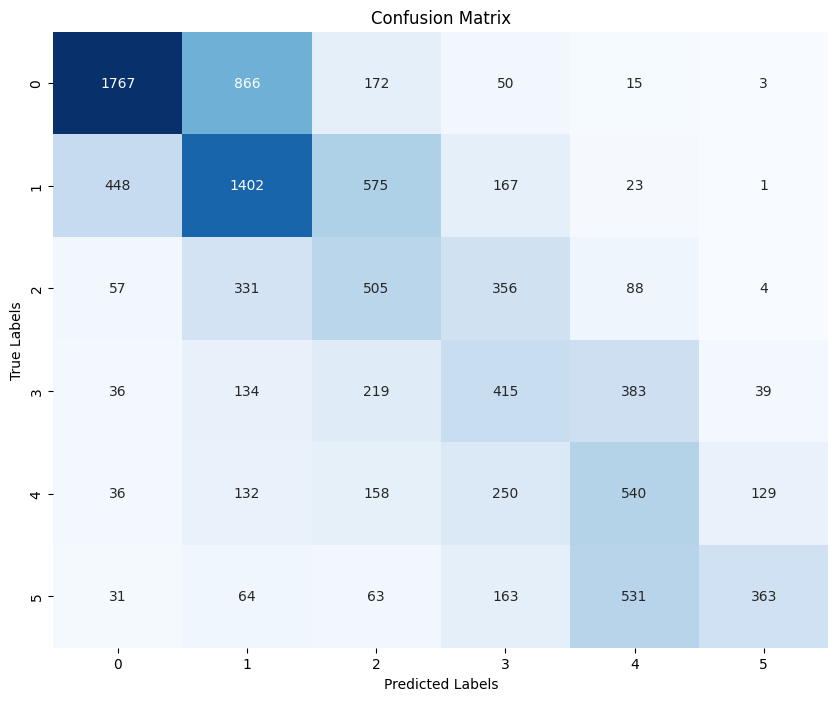

In [ ]:
preds_array = np.array(all_folds_preds)
labels_array = np.array(all_folds_labels)

kappa_score = cohen_kappa_score(labels_array, preds_array, weights='quadratic')
print(f"Overall CV Score: {kappa_score:.4f}")

cm = confusion_matrix(labels_array, preds_array)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Plot loss curves

{'epoch': 0, 'fold': 0, 'train_loss': 1.7369354442215352, 'tune_loss': 1.6874535224654459, 'kappa': 0.6300120864556678}
{'epoch': 1, 'fold': 0, 'train_loss': 1.4596098898390486, 'tune_loss': 1.425213463378675, 'kappa': 0.6594112140951159}
{'epoch': 2, 'fold': 0, 'train_loss': 1.2835454517034681, 'tune_loss': 1.344808794332273, 'kappa': 0.746124773795451}
{'epoch': 3, 'fold': 0, 'train_loss': 1.1719341943641222, 'tune_loss': 1.267523847023646, 'kappa': 0.6955763705492455}
{'epoch': 4, 'fold': 0, 'train_loss': 1.0842306807365185, 'tune_loss': 1.5853703984708496, 'kappa': 0.561526189142626}
{'epoch': 5, 'fold': 0, 'train_loss': 0.949827422325558, 'tune_loss': 1.3889919212370208, 'kappa': 0.7159207662915648}
{'epoch': 6, 'fold': 0, 'train_loss': 0.8389622589032983, 'tune_loss': 2.1504094340584494, 'kappa': 0.5966458088038101}
{'epoch': 7, 'fold': 0, 'train_loss': 0.7197940898775813, 'tune_loss': 1.7408082843729944, 'kappa': 0.6742210506911648}
{'epoch': 8, 'fold': 0, 'train_loss': 0.653688

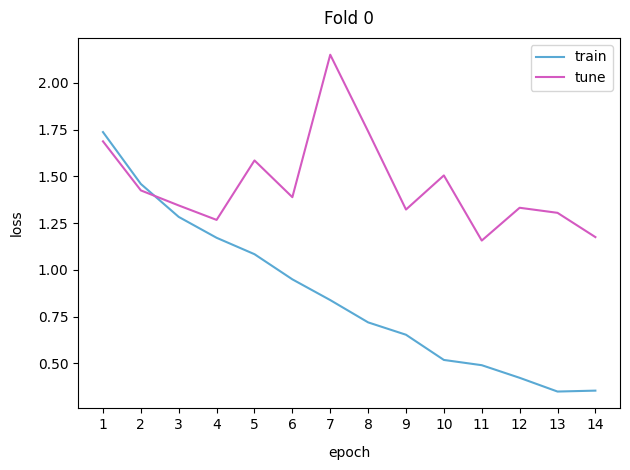

{'epoch': 0, 'fold': 1, 'train_loss': 1.7984813497709695, 'tune_loss': 1.7144331845370206, 'kappa': 0.5337806983388049}
{'epoch': 1, 'fold': 1, 'train_loss': 1.4805088008151335, 'tune_loss': 1.485250674233292, 'kappa': 0.6767345917694723}
{'epoch': 2, 'fold': 1, 'train_loss': 1.3509440094413911, 'tune_loss': 1.3475259952472918, 'kappa': 0.7163393797839526}
{'epoch': 3, 'fold': 1, 'train_loss': 1.2515728587915642, 'tune_loss': 1.227004213405378, 'kappa': 0.7364434385452991}
{'epoch': 4, 'fold': 1, 'train_loss': 1.1335825893808813, 'tune_loss': 1.2076109463518316, 'kappa': 0.7449211178840199}
{'epoch': 5, 'fold': 1, 'train_loss': 1.0289762361356742, 'tune_loss': 1.3269211469274578, 'kappa': 0.7300580584519829}
{'epoch': 6, 'fold': 1, 'train_loss': 0.8845385252583099, 'tune_loss': 1.4845138801769777, 'kappa': 0.7050098651155425}
{'epoch': 7, 'fold': 1, 'train_loss': 0.783350693617341, 'tune_loss': 1.2603042102221287, 'kappa': 0.7420512849347342}
{'epoch': 8, 'fold': 1, 'train_loss': 0.701

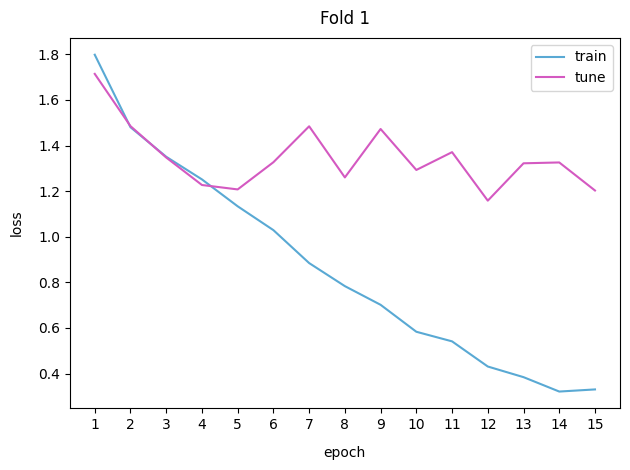

{'epoch': 0, 'fold': 2, 'train_loss': 1.794611514460968, 'tune_loss': 1.856642915805181, 'kappa': 0.5641271037457236}
{'epoch': 1, 'fold': 2, 'train_loss': 1.4270313514234085, 'tune_loss': 3.1651614355318474, 'kappa': 0.5031249827156792}
{'epoch': 2, 'fold': 2, 'train_loss': 1.353807882562612, 'tune_loss': 1.413024727864699, 'kappa': 0.718913945370923}
{'epoch': 3, 'fold': 2, 'train_loss': 1.2097679550096423, 'tune_loss': 1.728722414825902, 'kappa': 0.5714522987501975}
{'epoch': 4, 'fold': 2, 'train_loss': 1.098822578425098, 'tune_loss': 1.6046910238988472, 'kappa': 0.6994543365442362}
{'epoch': 5, 'fold': 2, 'train_loss': 1.0230988864059622, 'tune_loss': 1.8383458507783486, 'kappa': 0.711389109686451}
{'epoch': 6, 'fold': 2, 'train_loss': 0.9091472060818218, 'tune_loss': 1.3302609975590851, 'kappa': 0.7235144826846247}
{'epoch': 7, 'fold': 2, 'train_loss': 0.802351609083992, 'tune_loss': 1.4899766516504866, 'kappa': 0.7006329245988205}
{'epoch': 8, 'fold': 2, 'train_loss': 0.734741581

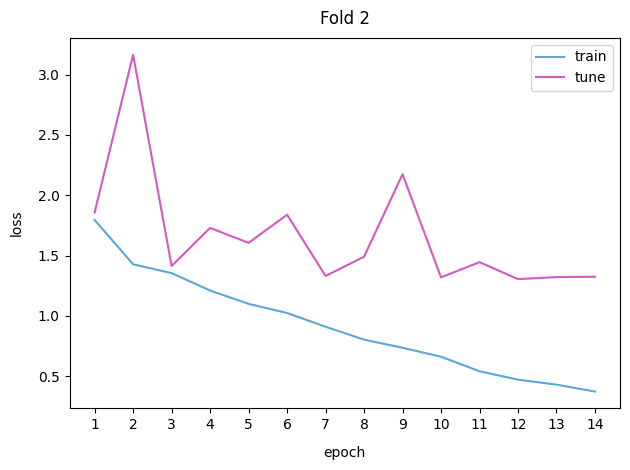

{'epoch': 0, 'fold': 3, 'train_loss': 1.8336970523815852, 'tune_loss': 2.5017981839902474, 'kappa': 0.4130969250081433}
{'epoch': 1, 'fold': 3, 'train_loss': 1.468640255516973, 'tune_loss': 1.8229763500618212, 'kappa': 0.6585369728048799}
{'epoch': 2, 'fold': 3, 'train_loss': 1.3468385001466918, 'tune_loss': 2.3417214906576906, 'kappa': 0.28159376639335243}
{'epoch': 3, 'fold': 3, 'train_loss': 1.2809098241113988, 'tune_loss': 1.3494443546641957, 'kappa': 0.7382511401627867}
{'epoch': 4, 'fold': 3, 'train_loss': 1.1381696226872489, 'tune_loss': 1.4366291649413832, 'kappa': 0.6416909082238489}
{'epoch': 5, 'fold': 3, 'train_loss': 1.0391841438007645, 'tune_loss': 2.7177665002418285, 'kappa': 0.5369531956249365}
{'epoch': 6, 'fold': 3, 'train_loss': 0.9189333686601318, 'tune_loss': 1.2327692743503686, 'kappa': 0.7590774274960966}
{'epoch': 7, 'fold': 3, 'train_loss': 0.8270272658514445, 'tune_loss': 1.2037170016404355, 'kappa': 0.7669838310809609}
{'epoch': 8, 'fold': 3, 'train_loss': 0.

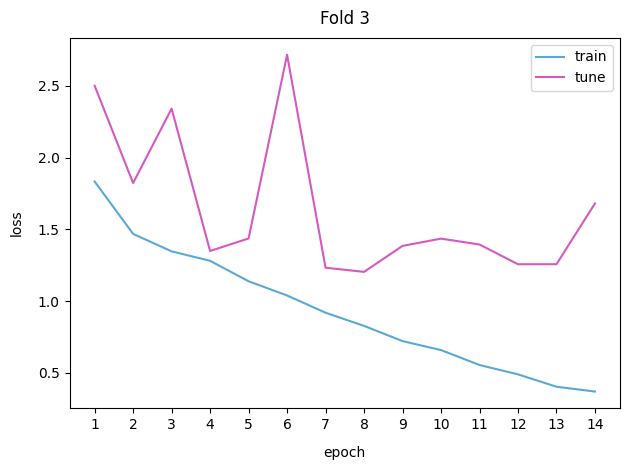

In [ ]:
import matplotlib.pyplot as plt

for fold in range(nfolds):
    with open(f'/kaggle/working/logs/log_{fname}_{fold}.json') as f:
        d = json.load(f)
        epoch = []
        train_loss = []
        tune_loss = []
        kappa = []
        for sd in d:
            print(sd)
            epoch.append(sd['epoch'])
            train_loss.append(sd['train_loss'])
            tune_loss.append(sd['tune_loss'])
            kappa.append(sd['kappa'])



    plt.figure(dpi=100)
    plt.plot(train_loss, label='train', color="#59A9D4")
    plt.plot(tune_loss, label='tune', color="#D459C1")

    plt.title(f'Fold {fold}', pad=10)
    plt.xlabel('epoch', labelpad=10)
    plt.ylabel('loss', labelpad=10)
    plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))  # Assuming epochs start at 1
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'log_{fname}_{fold}.png')
    plt.show()

### Mock predictions